## Naive Bayes Classifier Generative Model

In this notebook in the build your own model series, I will attempt to make a generative model to classify the flowers in the Iris dataset, using the Naive Bayes classifier. This assumes independence between the predictors. This is obviously an incorrect assumption in this case, however, the Introduction to Statistical Learning (ISLP) states this often makes for an effective model regardless. Moreover, the purpose of this notebook is to create a functioning model, rather than an effective one.

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
df = datasets.load_iris(as_frame=True)
X = df.data.values
y = df.target

We need to calculate independent density functions f_kj - the desnity function for class k and jth predictor, and pi_k. K = 3 (species of flower) and p = 4 (predictors).
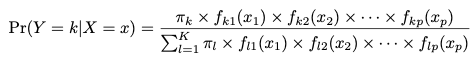
pi_k is just the proportion of kth class in the training data set.

In [35]:
pd.Series(y).value_counts()

target
0    50
1    50
2    50
Name: count, dtype: int64

In [608]:
df.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

The data is split equally between the 3 species.

In [229]:
pi = [50/150 for i in range(3)]

For estimating f_kj we are going to have to make some assumption about the distribution of each feature, for each class respectively. Hence, let's view the histograms of each feature, split by species:

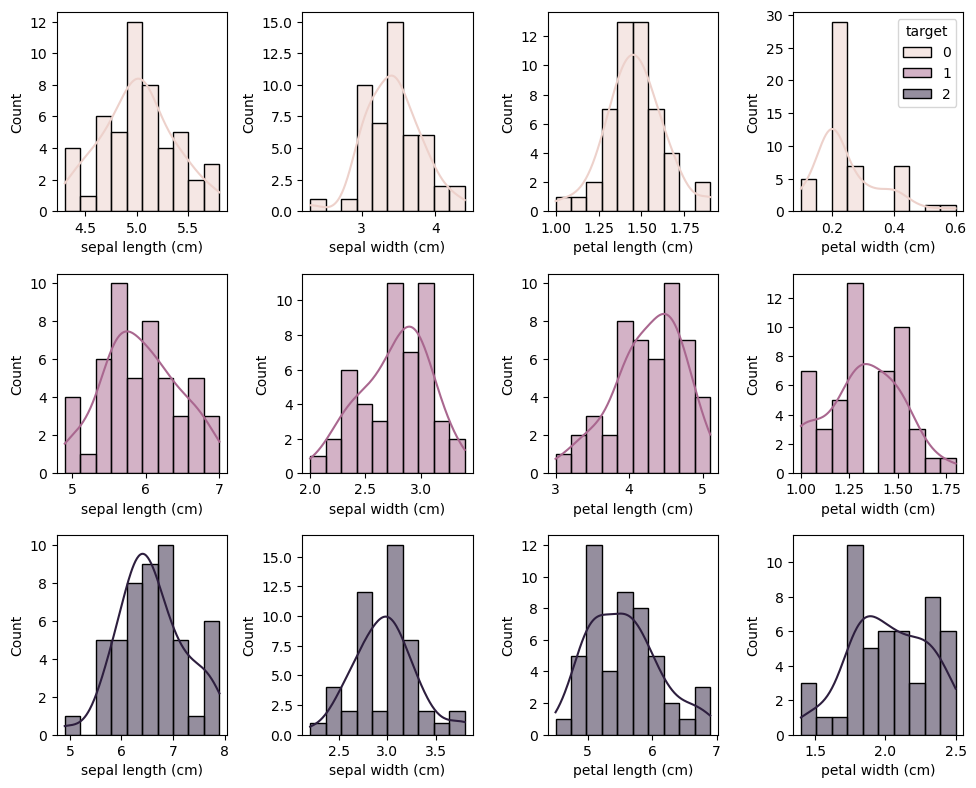

In [600]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10,8))
sns.histplot(data=df.data[:50], x="sepal length (cm)", ax=axes[0,0],hue=df.target, legend=False, kde=True, bins=10)
sns.histplot(data=df.data[:50], x="sepal width (cm)", ax=axes[0,1],hue=df.target, legend=False,  kde=True, bins=10)
sns.histplot(data=df.data[:50], x="petal length (cm)", ax=axes[0,2],hue=df.target, legend=False,  kde=True, bins=10)
sns.histplot(data=df.data[:50], x="petal width (cm)", ax=axes[0,3],hue=df.target, legend=True,  kde=True, bins=10)
sns.histplot(data=df.data[50:100], x="sepal length (cm)", ax=axes[1,0],hue=df.target, legend=False,  kde=True, bins=10)
sns.histplot(data=df.data[50:100], x="sepal width (cm)", ax=axes[1,1], hue=df.target, legend=False, kde=True, bins=10)
sns.histplot(data=df.data[50:100], x="petal length (cm)", ax=axes[1,2],hue=df.target, legend=False,  kde=True, bins=10)
sns.histplot(data=df.data[50:100], x="petal width (cm)", ax=axes[1,3],hue=df.target, legend=False,  kde=True, bins=10)
sns.histplot(data=df.data[100:], x="sepal length (cm)", ax=axes[2,0],hue=df.target, legend=False,  kde=True, bins=10)
sns.histplot(data=df.data[100:], x="sepal width (cm)", ax=axes[2,1],hue=df.target, legend=False,  kde=True, bins=10)
sns.histplot(data=df.data[100:], x="petal length (cm)", ax=axes[2,2],hue=df.target, legend=False,  kde=True, bins=10)
sns.histplot(data=df.data[100:], x="petal width (cm)", ax=axes[2,3], hue=df.target, legend=False, kde=True, bins=10)
plt.tight_layout()

According to ISLP we can estimate f_kj(x) by determing the proportion of is class in a certain bin of a histogram, using a Kernel Desnity Estimator or using a normal assumption for each class and feature. The normal assumption seems reasonable for the first 3 features for each class, whereas petal width is less normal. Let's give the first option a go as it seems the most simple. Let's write the f_kj(x) density function, where k is the class (0, 1, 2), j is the feature: 0=sepal length, 1=sepal width, 2=petal length, 3=petal width and x is the input / feature value. 

In [343]:
def density_function_kj(k: int, j: int, x):
    X_k_j = X[50*k:50+50*k,j] # Define the section of the data table for the relevant class, this is simple given that the table is split into 50 entries for each class
    bins = np.histogram(X_k_j, bins=10) # Create the histogram bins for the relevant data
    f = 0
    for i in range(len(bins[0])): # Find the quantity for the relevant bin and divide by 50 to find proportion
        if x >= bins[1][i] and x < bins[1][i+1]:
            f = bins[0][i] / 50
        elif x == bins[1][-1]:
            f = bins[0][0] / 50
        else:
            pass
    return f

Let's test this function. Let's say k=1, j=2 and x=5. This would be the posterior probability that the flower is a Setosa, given that the petal width is 0.21.

In [603]:
density_function_kj(k=0,j=3,x=0.21)

0.58

This states that 58% of the Setosa flowers have a petal width in the bin that includes 0.21. Looking at the histogram above this seems correct. Let's check the actual numbers:

In [421]:
np.histogram(df.data[y == 0]["petal width (cm)"], bins=10)

(array([ 5,  0, 29,  7,  0,  0,  7,  0,  1,  1]),
 array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ]))

Here we can see that bin with 0.21 cm in has 29 entries, which is 58% of the 50 data points, hence our density function is working. Let's try one more:

In [605]:
density_function_kj(k=2,j=0,x=5) * 50

1.0

We have 1 virginica flower with a sepal length in the bin containing 5 cm. 

In [609]:
np.histogram(df.data[y == 2]["sepal length (cm)"], bins=10)

(array([ 1,  0,  5,  5,  8,  9, 10,  5,  1,  6]),
 array([4.9, 5.2, 5.5, 5.8, 6.1, 6.4, 6.7, 7. , 7.3, 7.6, 7.9]))

We can see this has worked again.

Now we can write the full probability function above, to find the probability that Y = k given that X = x.

In [612]:
def Prob_YgivenX(k: int, X: np.array):
    denom = 0 # Calculate the denominator first
    for l in range(3): # for the sum of 1 to K=3
        mult = 1  # Define the product of the density functions within the sum
        for i in range(4): # for the product from j=1 to 4
            mult = mult * density_function_kj(l, i, X[i])
        denom = denom + mult # Sum over k
        denom * pi[l]  # Multiply by pi
    
    nominator = 1 
    for i in range(4): # for the product from j=1 to 4
        nominator = nominator * density_function_kj(k, i, X[i])
    nominator * pi[k] # Multiply by pi
    return nominator / denom    

Let's look at the probabilities for Y = K given X for each X in the dataset viewing a snippet of the outputs.

In [613]:
probs = []
for i in range(150):
    probs.append([Prob_YgivenX(k=0, X=X[i]),Prob_YgivenX(k=1, X=X[i]),Prob_YgivenX(k=2, X=X[i])])
print(probs[:5])
print(probs[-5:])

[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0]]
[[0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.03517587939698494, 0.964824120603015]]


The classifier seems to be working well overall. Let's right a formula that classifies the prediction for us given the probabilities and make some predictions.

In [614]:
def classify(X: np.array):
    k = pd.Series([Prob_YgivenX(k=0, X=X),Prob_YgivenX(k=1, X=X),Prob_YgivenX(k=2, X=X)]).idxmax()
    return k

Now we can make a set of predictions on our training dataset to see how it performs:

In [616]:
predict = []
for i in range(150):
    predict.append(classify(X=X[i]))

Now we can test the effectiveness of our model.

In [618]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y,predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.96      0.90      0.93        50
           2       0.91      0.96      0.93        50

    accuracy                           0.95       150
   macro avg       0.95      0.95      0.95       150
weighted avg       0.95      0.95      0.95       150



In [619]:
confusion_matrix(y,predict)

array([[50,  0,  0],
       [ 0, 45,  5],
       [ 0,  2, 48]])

When looking at whether I can re-create this model using SKLearn I have found that using the histogram method, otherwise known as multinomial classification, is only really used for categorical data and hence SKLearn does not have a version of this for us to compare against. Let's try using a Gaussian distribution instead. We need to redefine the desnity functions:

In [633]:
def density_function_kj_norm(k: int, j: int, x):
    X_k_j = X[50*k:50+50*k,j] 
    mu_kj = X_k_j.mean() # Define the mean for class k and feature j
    var_kj = X_k_j.var() # Define the variance for class k and feature j
    norm_pdf = np.exp( - ((x-mu_kj) ** 2 / var_kj) / 2 ) / (2 * np.pi * var_kj) ** 0.5 # Define Gaussian pdf
    return norm_pdf

Let's check that works against the Gaussian pdf in scipy:

In [634]:
from scipy.stats import norm
[density_function_kj_norm(k=2,j=1,x=2), norm.pdf(2, X[50*2:50+50*2,1].mean(), np.sqrt(X[50*2:50+50*2,1].var()))]

[0.011902405830842337, 0.01190240583084236]

We can re-use our probability function from earlier but sub in our new posterior probability:

In [635]:
def Prob_YgivenX(k: int, X: np.array):
    denom = 0
    for l in range(3): # for the sum of 1 to K=3
        mult = 1
        for i in range(4): # for the multiplication from 1 to p=4
            mult = mult * density_function_kj_norm(l, i, X[i])
        mult
        denom = denom + mult
    
    
    nominator = 1
    for i in range(4): # for the multiplication from 1 to p=4
        nominator = nominator * density_function_kj_norm(k, i, X[i])
            
    return round(nominator / denom , 4)

I have rounded the output just to view the results better.

In [636]:
probs = []
for i in range(150):
    probs.append([Prob_YgivenX(k=0, X=X[i]),Prob_YgivenX(k=1, X=X[i]),Prob_YgivenX(k=2, X=X[i])])
print(probs[:5])
print(probs[-5:])

[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0]]
[[0.0, 0.0, 1.0], [0.0, 0.0254, 0.9746], [0.0, 0.0004, 0.9996], [0.0, 0.0, 1.0], [0.0, 0.056, 0.944]]


Again, this seems to be working well. Let's make some predictions:

In [637]:
def classify(X: np.array):
    k = pd.Series([Prob_YgivenX(k=0, X=X),Prob_YgivenX(k=1, X=X),Prob_YgivenX(k=2, X=X)]).idxmax()
    return k

predict = []
for i in range(150):
    predict.append(classify(X=X[i]))

Let's run an SKLearn example as see if our results match:

In [643]:
from sklearn import naive_bayes
nb_model = naive_bayes.GaussianNB(priors=None)

In [644]:
nb_model.fit(X,y)

GaussianNB()

In [645]:
predict_sk = nb_model.predict(X)

Let's check if our predictions match:

In [646]:
np.allclose(predict, predict_sk, atol=0)

True

And the probabilities:

In [647]:
np.allclose(nb_model.predict_proba(X),probs, atol=0.0001)

True

Great! We have successfully built a Gaussian Bayes classifier in Python. The usual caveats apply to this use of the model that we are testing the model on the training set and not separate test, however as stated above, we are just trying the get the model to work. Let's have a quick look into the results:

In [649]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y,predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.94      0.94      0.94        50
           2       0.94      0.94      0.94        50

    accuracy                           0.96       150
   macro avg       0.96      0.96      0.96       150
weighted avg       0.96      0.96      0.96       150



In [650]:
confusion_matrix(y,predict)

array([[50,  0,  0],
       [ 0, 47,  3],
       [ 0,  3, 47]])

We an see we have slightly improved the accuracy when compared to the histogram classifier. Again, it is very good at predicting the Setosa species (k=0) and slightly lower when predicting the others. This is expected as there is a much greater crossover of those two species in the features:

array([<Axes: xlabel='sepal length (cm)', ylabel='sepal width (cm)'>,
       <Axes: xlabel='petal length (cm)', ylabel='petal width (cm)'>],
      dtype=object)

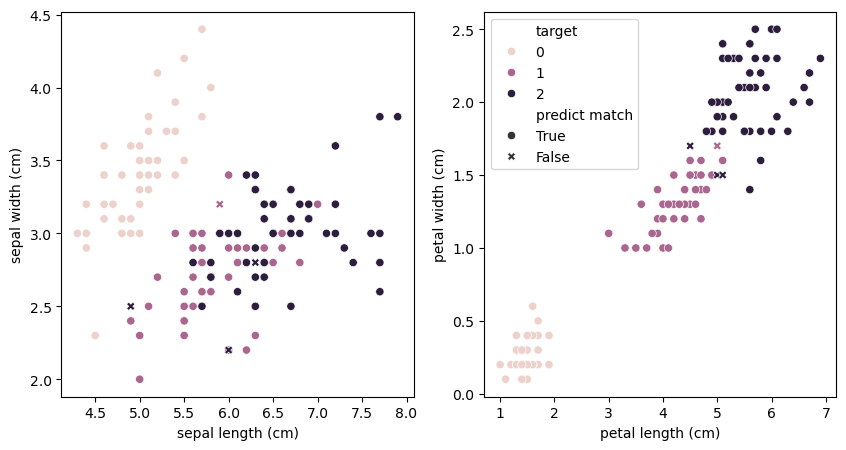

In [675]:
data = pd.DataFrame(df.data)
data["target"] = y
data["predict"] = predict
data["predict match"] = (y == predict)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.scatterplot(data=data, x="sepal length (cm)", y="sepal width (cm)", hue="target", 
                style="predict match", style_order=[True,False], ax=axes[0], legend=False)
sns.scatterplot(data=data, x="petal length (cm)", y="petal width (cm)", hue="target", 
                style="predict match", style_order=[True,False], ax=axes[1], legend=5)

axes

We can see that predictions are much more reliably based on the petal length and width. It would be interesting to plot the decision boundaries for the pairs of features. I will just do this between the sepal and petal features, to avoid too many graphs. First we need to define couple more extra models:

In [572]:
from sklearn import naive_bayes
nb_model_sepal = naive_bayes.GaussianNB(priors=None)
nb_model_sepal.fit(X[:,0:2],y)
nb_model_petal = naive_bayes.GaussianNB(priors=None)
nb_model_petal.fit(X[:,2:],y)

GaussianNB()

In [676]:
predict_sepal = nb_model_sepal.predict(X[:,0:2])
predict_petal = nb_model_petal.predict(X[:,2:])

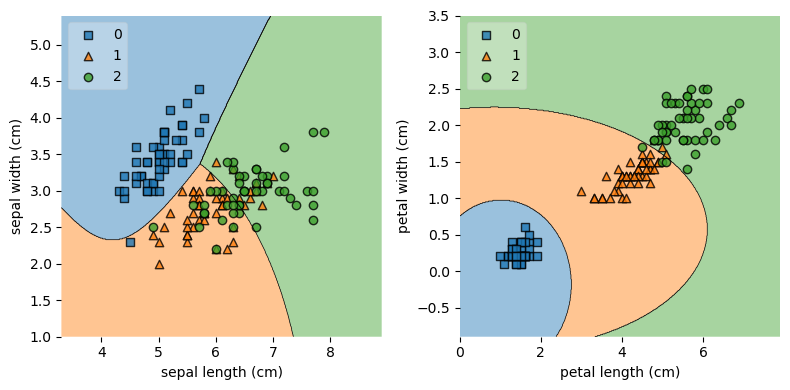

In [677]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
plot_decision_regions(X[:,0:2], y.values, clf=nb_model_sepal, legend=2, ax=axes[0])
plot_decision_regions(X[:,2:], y.values, clf=nb_model_petal, legend=2, ax=axes[1])

axes[0].set_xlabel("sepal length (cm)")
axes[0].set_ylabel("sepal width (cm)")
axes[1].set_xlabel("petal length (cm)")
axes[1].set_ylabel("petal width (cm)")
plt.tight_layout()

Here it is clear to see that petal length and width are the more decisive features in determining the species.